<h1 style="font-size:2.5rem;color:purple;">Artificial Intelligence II</h1>
<h1 style="font-size:1.5rem;color:purple;">Deep Learning for Natural Language Processing (NLP)</h1>

In this assignment, we develop a sentiment classifier by fine-tuning the pretrained model **BERT** in Python on a given Twitter dataset  
 (the same dataset used in Logistic Regression and DNN project).  

The dataset consists of three files: *train_dataset.csv, val_dataset.csv, test_dataset.csv*.  
Train and Val consists of three columns: **ID, Text, Label**, and Test consists of two columns: **ID, Text**.

In [1]:
# Import libraries

import pandas as pd

import warnings

import re

# For plots
import matplotlib.pyplot as plt
import seaborn as sns

# For wordclouds
from wordcloud import WordCloud
from collections import Counter

import numpy as np

import torch

# For BERT tokenizer/vectorization
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader

# For BERT
from transformers import BertForSequenceClassification
import torch.nn as nn
import torch.optim as optim

# For metrics and metric visualization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

2025-05-01 12:13:48.048820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746101628.240638      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746101628.295910      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(torch.cuda.is_available())     # True if GPU is available
print(torch.cuda.current_device())   # GPU we use 
print(torch.cuda.get_device_name(0)) # Name of GPU

True
0
Tesla P100-PCIE-16GB


In [3]:
# Ingore warnings
warnings.filterwarnings("ignore")

In [4]:
np.random.seed(42)

Load the given data (*train.csv* to use for training, *val.csv* to use for validation of training and *test.csv* to use for predictions)

In [5]:
# Read train dataset (to use for training)
df_train = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/train_dataset.csv')

# Read val dataset (to use for validation of training)
df_val = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/val_dataset.csv')

# Read test dataset (to use for predictions)
df_test = pd.read_csv('/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/test_dataset.csv')

Let's take a look at the train dataset (the other two datasets have a similar structure to this one)

In [6]:
df_train

,ID,Text,Label
0,189385,@whoisralphie dude I'm so bummed ur leaving!,0
1,58036,"oh my god, a severed foot was foun in a wheely...",0
2,190139,I end up &quot;dog dialing&quot; sumtimes. Wha...,1
3,99313,@_rachelx meeeee toooooo!,0
4,157825,"I was hoping I could stay home and work today,...",0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i w...,0
148384,61015,another day gone by....time is moving so fast...,0
148385,36598,"fuck college, i'm just gonna marry rich. : fuc...",1
148386,83799,ZOMGZ NEW SONG FTW. remember that night. &lt;3,1


Now we will make some plots to take a look at the dataset before "Data Preprocessing"

Visualize the most frequent words per label

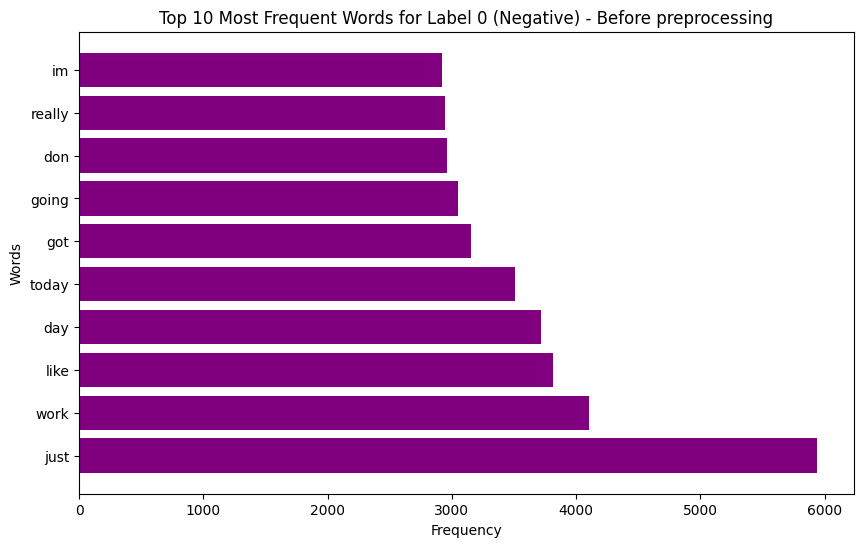

In [7]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

# Set label 
label = 0

# Filter the text for the selected label
text_label = df_train[df_train['Label'] == label]['Text']

# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)

# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label} (Negative) - Before preprocessing')

# Unzip the most common words and counts
words, counts = zip(*most_common_words)

# Create bar plot with Matplotlib
plt.barh(words, counts, color='purple')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

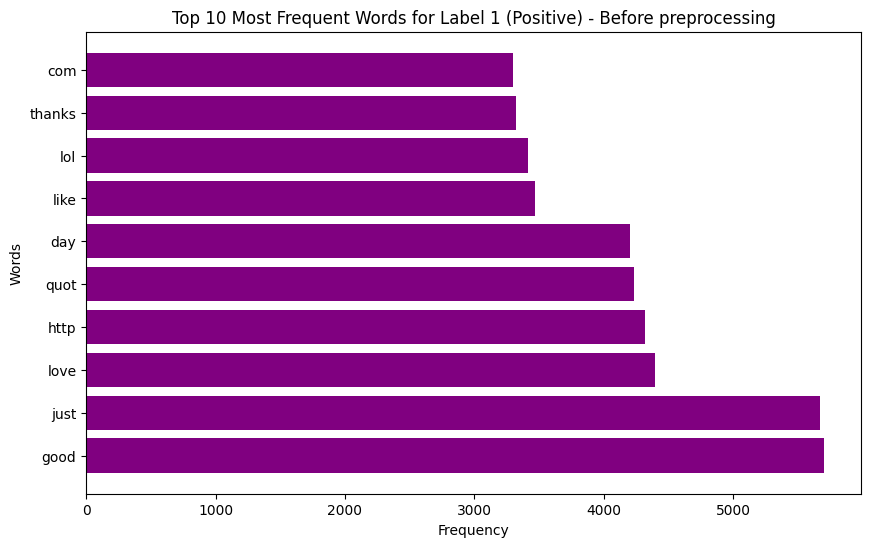

In [8]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

# Set label 
label = 1

# Filter the text for the selected label
text_label = df_train[df_train['Label'] == label]['Text']

# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)

# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label} (Positive) - Before preprocessing')

# Unzip the most common words and counts
words, counts = zip(*most_common_words)

# Create bar plot with Matplotlib
plt.barh(words, counts, color='purple')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Count and print the labels of Train and Validation set

In [9]:
# Count labels
label_counts = df_train["Label"].value_counts()

print("Labels in Train Set:")
print(f"Negative (0): {label_counts[0]}")
print(f"Positive (1): {label_counts[1]}")

Labels in Train Set:
Negative (0): 74192
Positive (1): 74196


In [10]:
# Count labels
label_counts = df_val["Label"].value_counts()

print("Labels in Validation Set:")
print(f"Negative (0): {label_counts[0]}")
print(f"Positive (1): {label_counts[1]}")

Labels in Validation Set:
Negative (0): 21197
Positive (1): 21199


The labels look balanced on both train and valitadion set.

<h1 style="font-size:1.5rem;color:purple;">Data Preprocessing</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we clean the datasets.</h1>

First we remove unwanted symbols/characters (e.g. URLs, @mentions, numbers/characters, hashtags).

In [11]:
# Function to clean text

def clean_text(text):
    # Replace URLs with word URL
    text = re.sub(r'http\S+|www\.\S+', 'URL', text)

    # Replace mentions/usernames with @user
    text = re.sub(r'@\w+', '@user', text)
    
    # Remove special characters, numbers, and punctuation, but keep some characters (like ?, !, @, .)
    text = re.sub(r'[^a-zA-Zά-ώΑ-Ω\s@!?\.]', '', text)
    
    # Remove hashtags but keep the words
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

Clean text column in every dataframe

In [12]:
# Clean only Text column
df_train['Text'] = df_train['Text'].apply(clean_text)
df_val['Text'] = df_val['Text'].apply(clean_text)
df_test['Text'] = df_test['Text'].apply(clean_text)

Convert all text to lowercase

In [13]:
def text_lower(text):
    # Convert to lowercase
    text = text.lower()

    return text

In [14]:
df_train['Text'] = df_train['Text'].apply(text_lower)
df_val['Text'] = df_val['Text'].apply(text_lower)
df_test['Text'] = df_test['Text'].apply(text_lower)

Now take a look at the same dataset as above, but cleaned (the other two datasets are cleaned as well)

In [15]:
df_train

,ID,Text,Label
0,189385,@user dude im so bummed ur leaving!,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes. whats d...,1
3,99313,@user meeeee toooooo!,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i wi...,0
148384,61015,another day gone by....time is moving so fast...,0
148385,36598,fuck college im just gonna marry rich. fuck co...,1
148386,83799,zomgz new song ftw. remember that night. lt,1


Drop rows with NaN values

In [16]:
# Drop NaN values
df_train = df_train.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_val = df_val.replace(r'^\s*$', pd.NA, regex=True).dropna()

Replace NaN rows in **Test** set with the word "unknown" (we can't remove NaN values in this set, because of Kaggle competition submission.csv size)

In [17]:
df_test['Text'] = df_test['Text'].fillna("").apply(lambda x: "unknown" if not x.strip() else x)

Now let's check if we have rows that are "non-english"

Function to check if 80% of a text is english

In [18]:
def is_mostly_english(text, threshold=0.8):
    words = text.split()
    if not words:
        return False

    # Keep !, ? and other characters in the end of the word
    english_like = [w for w in words if re.match(r'^[a-zA-Z@.!?\-]+$', w)]
    return len(english_like) / len(words) >= threshold

Check if the 80% of text is english, in every row (for all three sets)

In [19]:
# -------------------------------- TRAIN SET --------------------------------
# Check and add an extra column for "True/False" if a text is english or not
df_train['is_english'] = df_train['Text'].apply(lambda x: is_mostly_english(x))

# Check for non-english rows
non_english_rows_train = df_train[~df_train['is_english']]


# ------------------------------ VALIDATION SET ------------------------------
# Check and add an extra column for "True/False" if a text is english or not
df_val['is_english'] = df_val['Text'].apply(lambda x: is_mostly_english(x))

# Check for non-english rows
non_english_rows_val = df_val[~df_val['is_english']]


# --------------------------------- TEST SET ---------------------------------
# Check and add an extra column for "True/False" if a text is english or not
df_test['is_english'] = df_test['Text'].apply(lambda x: is_mostly_english(x))

# Check for non-english rows
non_english_rows_test = df_test[~df_test['is_english']]


Print results

In [20]:
print("Non-english rows in Train set:", len(non_english_rows_train))

print("Non-english rows in Validation set:", len(non_english_rows_val))

print("Non-english rows in Test set:", len(non_english_rows_test))

Non-english rows in Train set: 0
Non-english rows in Validation set: 0
Non-english rows in Test set: 0


Drop extra column that marks English/Non-English text

In [21]:
df_train = df_train.drop(columns=['is_english'])
df_val = df_val.drop(columns=['is_english'])
df_test = df_test.drop(columns=['is_english'])

Reduce repeated characters in 2 (e.g. meeeeee toooooo -> mee too)

Function to reduce repeated characters

In [22]:
# Function to reduce repeated characters to 2
def reduce_repeated_characters(text):
   
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Reduce characters repeated (3 or more times) to 2
    return text

Reduce repeated characters in Text columns

In [23]:
df_train['Text'] = df_train['Text'].apply(reduce_repeated_characters)
df_val['Text'] = df_val['Text'].apply(reduce_repeated_characters)
df_test['Text'] = df_test['Text'].apply(reduce_repeated_characters)

In [24]:
df_train

,ID,Text,Label
0,189385,@user dude im so bummed ur leaving!,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes. whats d...,1
3,99313,@user mee too!,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its too bad i wil...,0
148384,61015,another day gone by..time is moving so fast..,0
148385,36598,fuck college im just gonna marry rich. fuck co...,1
148386,83799,zomgz new song ftw. remember that night. lt,1


Replace some frequent slang words with their original form

Create a dictionary with slang and original words

In [25]:
# Create a dictionary with slang word and their original form
abbreviations = {
    "im": "i am",
    "ur": "you are",
    "u": "you",
    "bummed": "sad",
    "mee": "me",
    "soo": "so",
    "ily": "i love you",
    "ok": "okay",
    "oke": "okay",
    "noo": "no",
    "luv": "love",
    "fb": "facebook",
    "cuz": "because",
    "ikr": "i know",
    "kno": "know",
    "knoo": "know",
    "sos": "help",
    "omg": "oh my god",
    "zomgz": "oh my god",
    "smh": "disappointment",
    "bday": "birthday",
    "wtf": "what the fuck",
    "not happy": "sad",
    "lt": "love it",
    "ftw": "awesome",
    "ftww": "awesome",
    "sumtimes": "sometimes"
}

Function to replace slang words

In [26]:
# Function to replace slang
def replace_slang(text):
   
    for abbrev, full_form in abbreviations.items():
        text = re.sub(rf'\b{abbrev}\b', full_form, text, flags=re.IGNORECASE)
    
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

Replaced slang from all Text columns

In [27]:
df_train['Text'] = df_train['Text'].apply(replace_slang)
df_val['Text'] = df_val['Text'].apply(replace_slang)
df_test['Text'] = df_test['Text'].apply(replace_slang)

In [28]:
df_train

,ID,Text,Label
0,189385,@user dude i am so sad you are leaving!,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sometimes. whats ...,1
3,99313,@user me too!,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its too bad i wil...,0
148384,61015,another day gone by..time is moving so fast..,0
148385,36598,fuck college i am just gonna marry rich. fuck ...,1
148386,83799,oh my god new song awesome. remember that nigh...,1


Remove words "got", "oh" , "im" and "just" since they're frequent and meaningless words for both labels

In [29]:
# Function to remove words "got", "oh", "im" and "just" from text
def remove_words(text):
    
    cleaned_text = re.sub(r'\b(got|oh|just|im)\b', '', text, flags=re.IGNORECASE)
    return re.sub(r'\s+', ' ', cleaned_text).strip()

In [30]:
df_train['Text'] = df_train['Text'].apply(remove_words)
df_val['Text'] = df_val['Text'].apply(remove_words)
df_test['Text'] = df_test['Text'].apply(remove_words)

Drop NaN values after data cleaning (also replace NaN values with "unknown" for test set)

In [31]:
# Drop NaN values
df_train = df_train.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_val = df_val.replace(r'^\s*$', pd.NA, regex=True).dropna()

# Replace NaN
df_test['Text'] = df_test['Text'].fillna("").apply(lambda x: "unknown" if not x.strip() else x)

Below is the Train dataframe after data preprocessing

In [32]:
df_train

,ID,Text,Label
0,189385,@user dude i am so sad you are leaving!,0
1,58036,my god a severed foot was foun in a wheely bin...,0
2,190139,i end up quotdog dialingquot sometimes. whats ...,1
3,99313,@user me too!,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,love the jonas brothers its too bad i wil neve...,0
148384,61015,another day gone by..time is moving so fast..,0
148385,36598,fuck college i am gonna marry rich. fuck colle...,1
148386,83799,my god new song awesome. remember that night. ...,1


<h1 style="font-size:1.5rem;color:purple;">Analysis</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will try to visualize the data after preprocessing.</h1>

Create some wordclouds to make it clear and visible which words are used more often

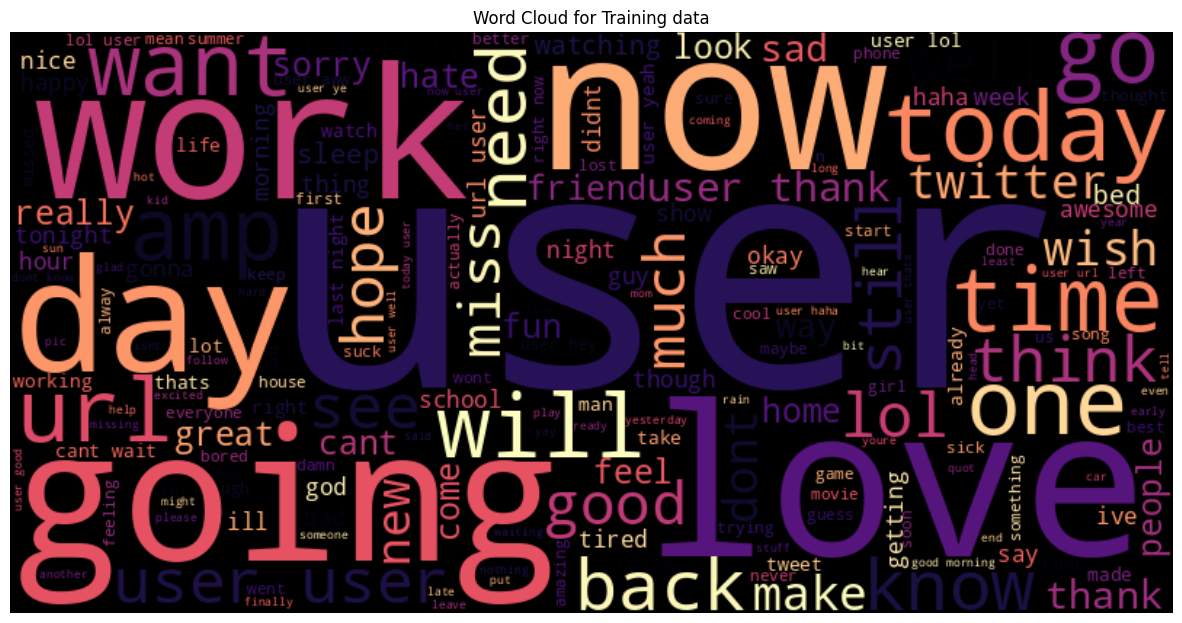

In [33]:
# Wordcloud for TRAINING DATA

# Combine all text entries into one string
text = " ".join(df_train['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Training data")
plt.axis("off")
plt.show()

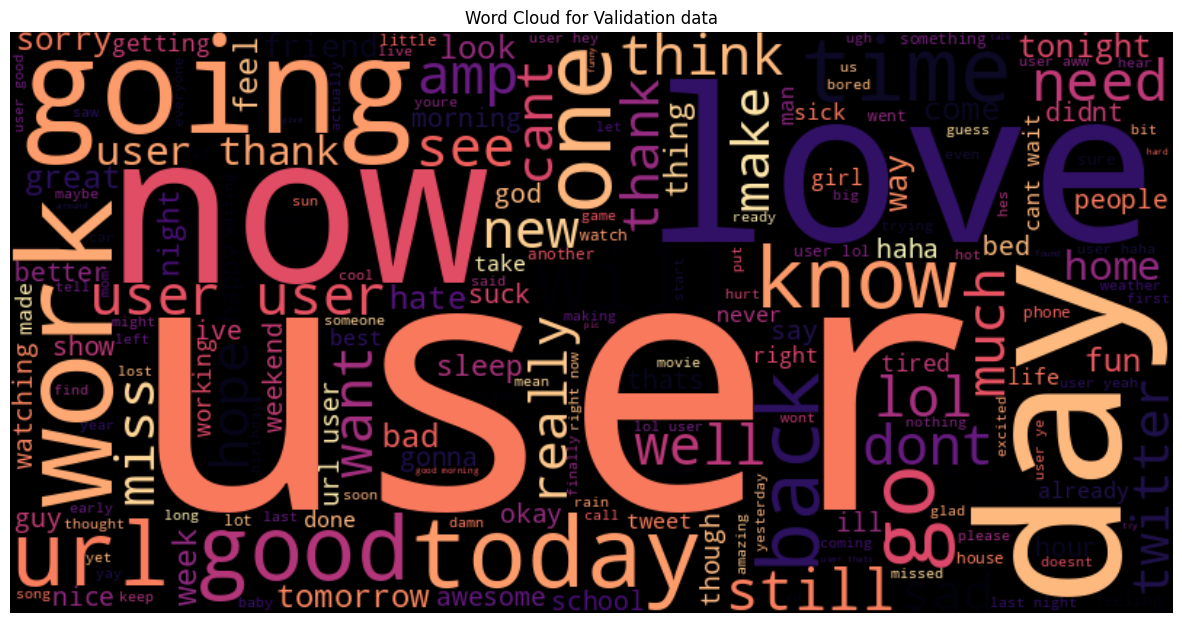

In [34]:
# Wordcloud for VALIDATION DATA

# Combine all text entries into one string
text = " ".join(df_val['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Validation data")
plt.axis("off")
plt.show()

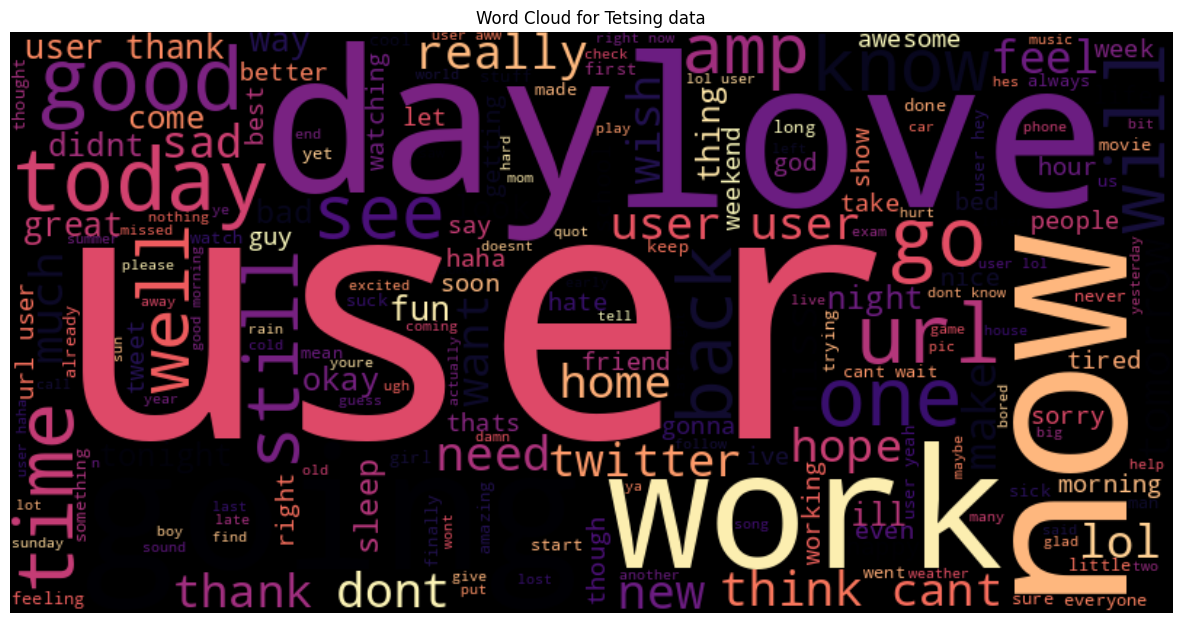

In [35]:
# Wordcloud for TESTING DATA

# Combine all text entries into one string
text = " ".join(df_test['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Tetsing data")
plt.axis("off")
plt.show()

Count and make a pie chart for the label distribution (1 for positive, 0 for negative) in every dataframe  
(Test dataframe doesn't have "Label" column)

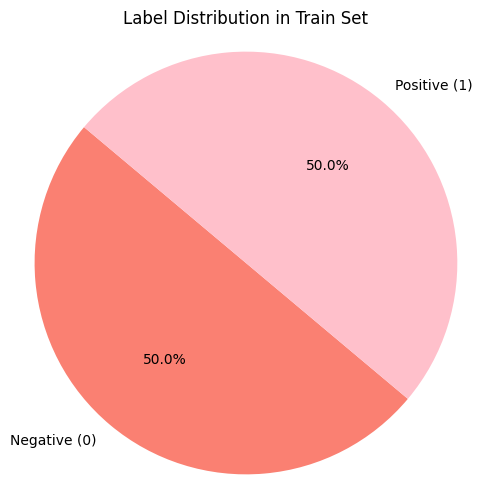

In [36]:
# Count labels
label_counts = df_train["Label"].value_counts()

# Define labels, counts and colors
labels = ['Negative (0)', 'Positive (1)']
sizes = [label_counts[0], label_counts[1]]
colors = ['salmon', 'pink']


# Create piechart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.title('Label Distribution in Train Set')
plt.axis('equal')               # Equal aspect ratio for perfect circle
plt.show()

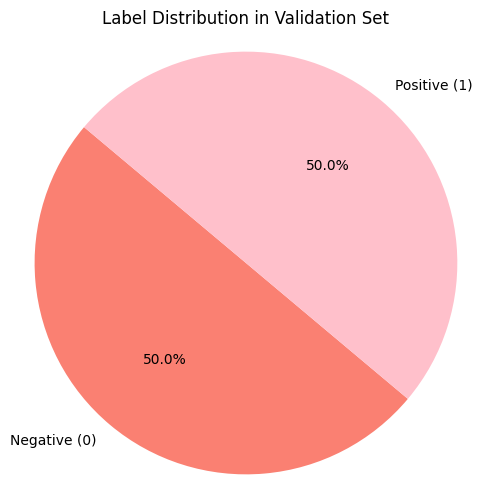

In [37]:
# Count labels
label_counts = df_val["Label"].value_counts()

# Define labels, counts and colors
labels = ['Negative (0)', 'Positive (1)']
sizes = [label_counts[0], label_counts[1]]
colors = ['salmon', 'pink']


# Create piechart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.title('Label Distribution in Validation Set')
plt.axis('equal')               # Equal aspect ratio for perfect circle
plt.show()

The labels seem to be balanced, even after data preprocessing, since we have about equal numbers of positives and negatives in both dataframes.

Make some plots showing the top 10 most frequent words per label (for train set)

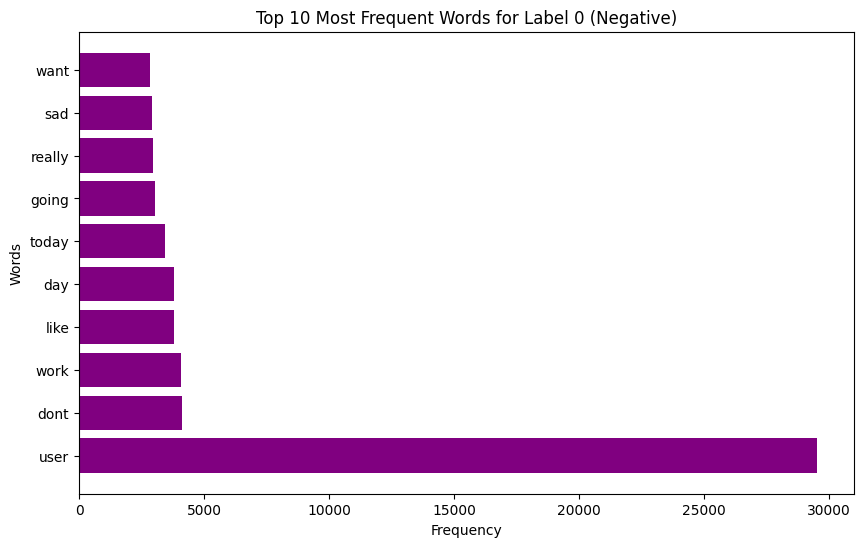

In [38]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

# Set label 
label = 0

# Filter the text for the selected label
text_label = df_train[df_train['Label'] == label]['Text']

# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)

# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label} (Negative)')

# Unzip the most common words and counts
words, counts = zip(*most_common_words)

# Create bar plot with Matplotlib
plt.barh(words, counts, color='purple')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

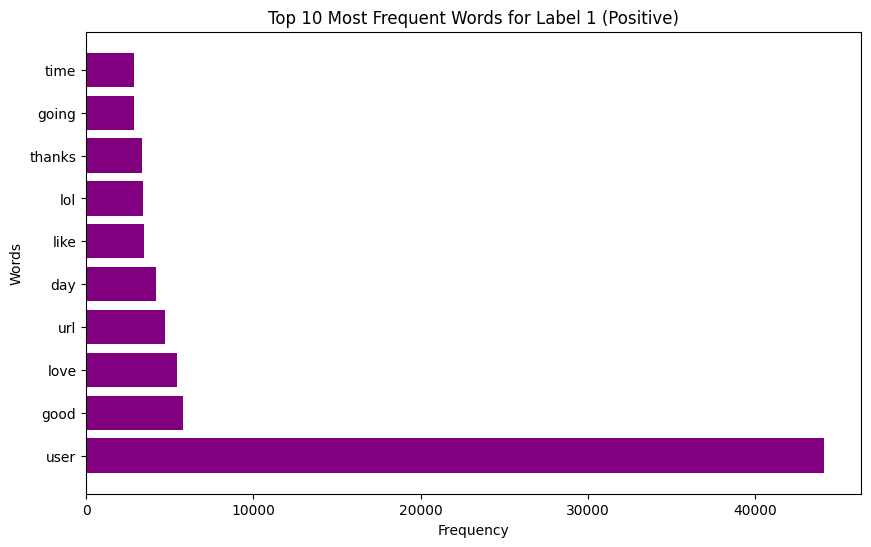

In [39]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

# Set label 
label = 1

# Filter the text for the selected label
text_label = df_train[df_train['Label'] == label]['Text']

# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)

# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label} (Positive)')

# Unzip the most common words and counts
words, counts = zip(*most_common_words)

# Create bar plot with Matplotlib
plt.barh(words, counts, color='purple')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

<h1 style="font-size:1.5rem;color:purple;">Vectorization</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will convert text/data into numerical form so that it can be used by machine learning models.</h1>

Load BERT tokenizer

In [40]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",  use_fast=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize text in datasets

In [41]:
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True) if labels is not None else None
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.has_labels = labels is not None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):

        if idx >= len(self.texts):
            raise IndexError(f"Index {idx} is out of bounds for dataset with length {len(self.texts)}.")

        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

        if self.has_labels:
            item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)
            
        return item

Create DataLoaders

In [42]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [43]:
train_dataset = TextDataset(df_train['Text'], df_train['Label'], tokenizer)
val_dataset = TextDataset(df_val['Text'], df_val['Label'], tokenizer)
test_dataset = TextDataset(df_test['Text'], tokenizer=tokenizer)

In [44]:
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

<h1 style="font-size:1.5rem;color:purple;">Training, Evaluation & Testing</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will train BERT model, using train data and validate its accuracy using val data. In the end we will test the trained model, using test data.</h1>

Define BERT pretrained model

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BERT_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, problem_type="single_label_classification")
BERT_model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Set criterion, otpimizer and number of epochs

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(BERT_model.parameters(), lr=2e-5, weight_decay=0.01)
EPOCHS = 3

Scheduler

In [47]:
from transformers import get_linear_schedule_with_warmup

# Number of training steps per epoch
total_steps = len(train_loader) * EPOCHS

# Set scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # Warmup for the first 10% of steps
    num_training_steps=total_steps            # All steps of training
)

Lists to keep train and validation losses and accuracies (to use in learning curve)

In [48]:
train_losses = [] 
val_losses = []
train_accuracies = []
val_accuracies = []

For progress bar

In [49]:
!pip install tqdm

In [50]:
from tqdm import tqdm

Train BERT model

In [51]:
for epoch in range(EPOCHS):
    
    # --- Training ---
    BERT_model.train()
    
    total_loss = 0
    train_preds, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = BERT_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        scheduler.step() 

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate and save train loss and accuracy
    train_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    BERT_model.eval()
    
    val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = BERT_model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate and save val loss and accuracy
    val_loss /= len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1 | Train Loss: 0.4150, Train Acc: 0.8048 | Val Loss: 0.3527, Val Acc: 0.8441


Epoch 2 | Train Loss: 0.3165, Train Acc: 0.8644 | Val Loss: 0.3581, Val Acc: 0.8494


Epoch 3 | Train Loss: 0.2628, Train Acc: 0.8917 | Val Loss: 0.3665, Val Acc: 0.8496


Evaluate trained BERT model and print metrics (accuracy, precision, recall, f1-score)

In [52]:
# Evaluation using val dataset to print metrics

BERT_model.eval()
val_preds, val_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = BERT_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_acc = accuracy_score(val_labels, val_preds)
val_prec = precision_score(val_labels, val_preds)
val_rec = recall_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds)

print(f"Accuracy:  {val_acc * 100:.2f}%")
print(f"Precision: {val_prec:.4f}")
print(f"Recall:    {val_rec:.4f}")
print(f"F1 Score:  {val_f1:.4f}")

Accuracy:  84.96%
Precision: 0.8582
Recall:    0.8375
F1 Score:  0.8477


Make predictions using test set and create submission.csv

In [53]:
BERT_model.eval()
test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = BERT_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        test_preds.extend(preds.cpu().numpy())

In [54]:
# Create DataFrame for submission
submission_df = pd.DataFrame({"ID": df_test["ID"], "Label": test_preds})

# Save to CSV file
submission_df.to_csv("submission.csv", index=False)

print("Predictions saved in submission.csv")

Predictions saved in submission.csv


Now we make some plots to visualize the performance of the model and check for over-fitting/under-fitting

**1. Confusion Matrix**

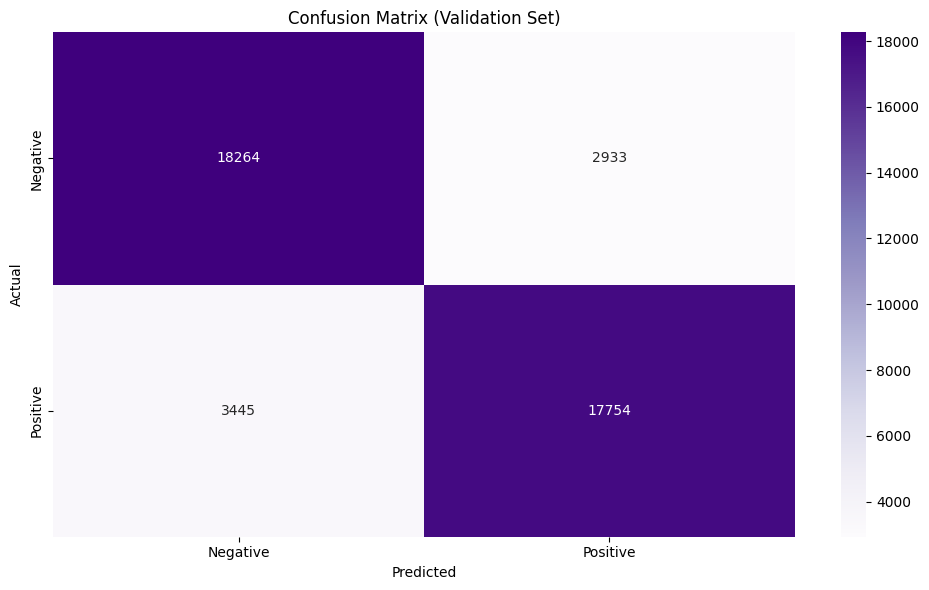

In [55]:
# Confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

**2. ROC Curve (Receiver Operating Characteristic)**

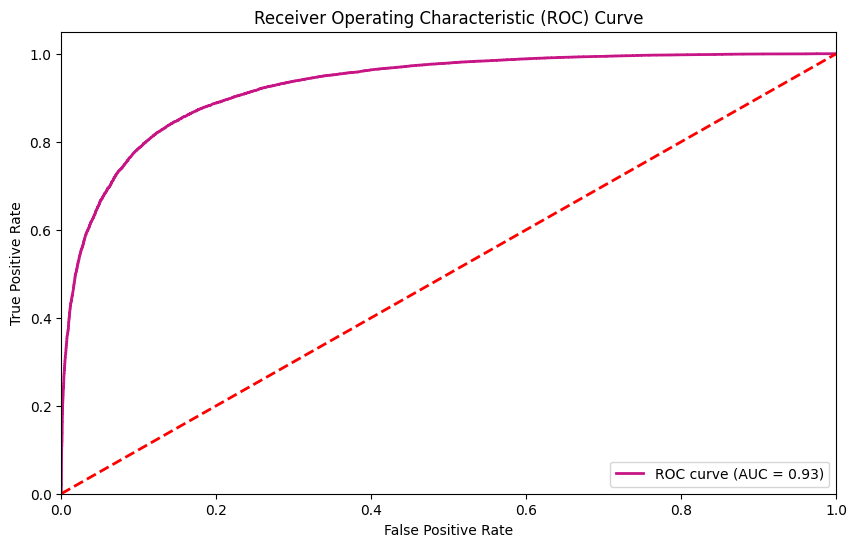

In [56]:
import torch.nn.functional as F

val_probs = []

BERT_model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = BERT_model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=1)
        val_probs.extend(probs[:, 1].cpu().numpy())  #  Probabilities


fpr, tpr, _ = roc_curve(val_labels, val_probs)
# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot for ROC Curve
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color="#C71585", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

**3. Learning Curve - Loss and Accuracy over epochs**

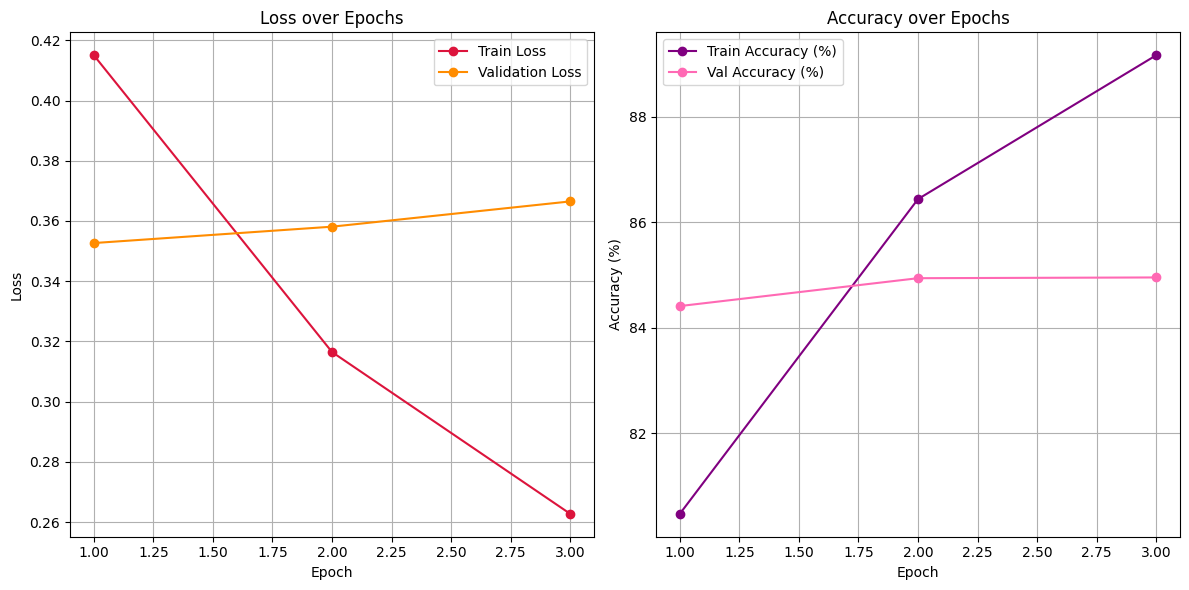

In [57]:
epochs_range = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', color='crimson', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', color='darkorange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in train_accuracies], label='Train Accuracy (%)', color='purple', marker='o')
plt.plot(epochs_range, [acc * 100 for acc in val_accuracies], label='Val Accuracy (%)', color='hotpink', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()